# Forecasting Consensus Expectations: Nonfarm Payrolls (NFP)
## Data Exploration

**Imports**

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib.dates as mdates
import statsmodels.api as sm

from tqdm.auto import tqdm
from scipy import stats, special
from scipy.optimize import brentq
from collections import defaultdict
from itertools import product
from scipy.stats import t as student_t, norm, binomtest, jarque_bera
from statsmodels.stats.diagnostic import het_breuschpagan

In [21]:
# read parquets
OUT_DIR = "../out"        
DF_FILE       = "df.parquet"
DF_FULL_FILE  = "df_full.parquet"

df       = pd.read_parquet(os.path.join(OUT_DIR, DF_FILE),      engine="pyarrow")
df_full  = pd.read_parquet(os.path.join(OUT_DIR, DF_FULL_FILE), engine="pyarrow")

print("df shape     :", df.shape)
print("df_full shape:", df_full.shape)

df shape     : (73219, 10)
df_full shape: (84667, 10)


**Data Exploration**

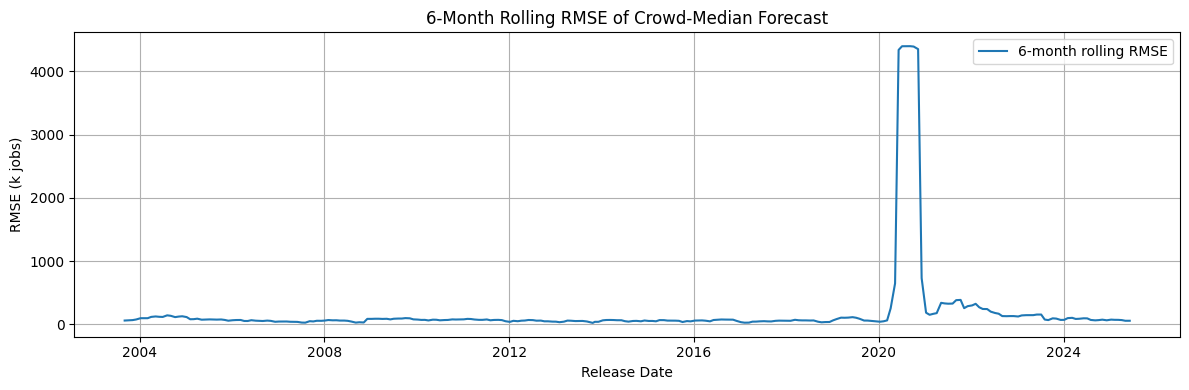

In [22]:
# Build one-row-per-release table of median forecast vs actual
median_vs_actual = (
    df_full.groupby("release_date")
           .agg(crowd_median=("forecast", "median"),
                actual      =("actual",   "first"))
           .dropna()
           .sort_index()
)

# Compute forecast error and rolling RMSE
median_vs_actual["err"] = median_vs_actual["crowd_median"] - median_vs_actual["actual"]

WINDOW = 6                       
median_vs_actual[f"rmse_{WINDOW}m"] = (
    median_vs_actual["err"]
      .rolling(WINDOW, min_periods=WINDOW)
      .apply(lambda x: np.sqrt(np.mean(x**2)), raw=True)
)

# Plot rolling RMSE of the crowd median
plt.figure(figsize=(12, 4))
plt.plot(median_vs_actual.index,
         median_vs_actual[f"rmse_{WINDOW}m"],
         label=f"{WINDOW}-month rolling RMSE")

plt.title(f"{WINDOW}-Month Rolling RMSE of Crowd-Median Forecast")
plt.xlabel("Release Date")
plt.ylabel("RMSE (k jobs)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

COVID (~2020-2022) should be filtered out if we want accuracy in naive point forecast

Contiguity windows:   0%|          | 0/3 [00:00<?, ?it/s]

6-mo tracking:   0%|          | 0/261 [00:00<?, ?it/s]

12-mo tracking:   0%|          | 0/255 [00:00<?, ?it/s]

24-mo tracking:   0%|          | 0/243 [00:00<?, ?it/s]

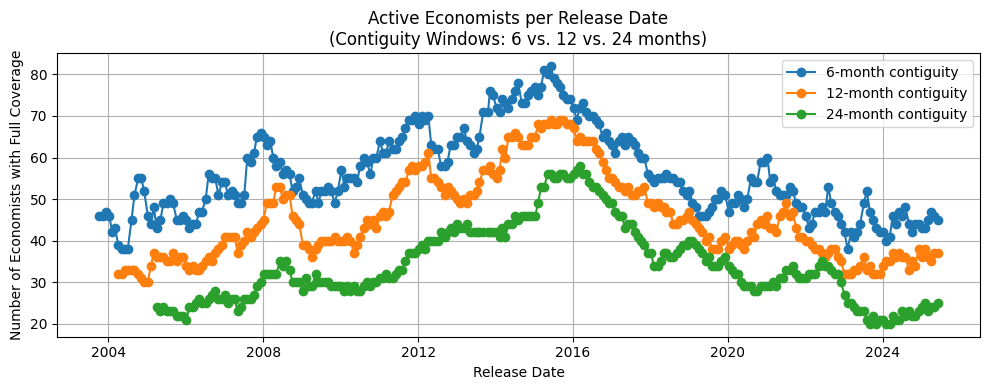

In [23]:
# prepare dates
dates = sorted(df_full["release_date"].unique())

contiguity_windows = [6, 12, 24]
active_counts = {}

for window in tqdm(contiguity_windows, desc="Contiguity windows"):
    counts = []
    for idx in tqdm(range(window, len(dates)),
                    desc=f"{window}-mo tracking",
                    leave=False):
        t            = dates[idx]
        window_dates = dates[idx-window:idx]
        hist         = df_full[df_full["release_date"].isin(window_dates)]
        valid        = (
            hist.groupby("economist")["forecast"]
                .apply(lambda s: s.notna().all())
        )
        counts.append((t, valid.sum()))
    active_counts[window] = pd.Series(
        [c for (_, c) in counts],
        index=[d for (d, _) in counts]
    )
    
plt.figure(figsize=(10, 4))
for window, series in active_counts.items():
    plt.plot(
        series.index,
        series.values,
        marker='o',
        label=f"{window}-month contiguity"
    )

plt.title("Active Economists per Release Date\n(Contiguity Windows: 6 vs. 12 vs. 24 months)")
plt.xlabel("Release Date")
plt.ylabel("Number of Economists with Full Coverage")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Visualize distribution of COVID-filtered dataframe**

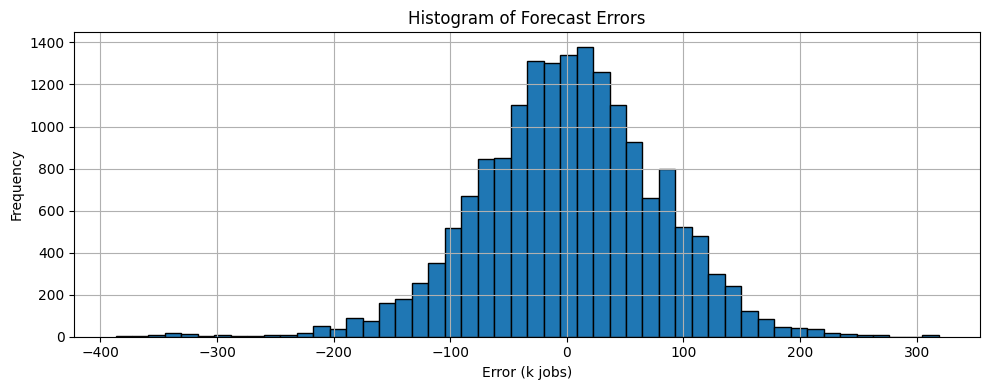

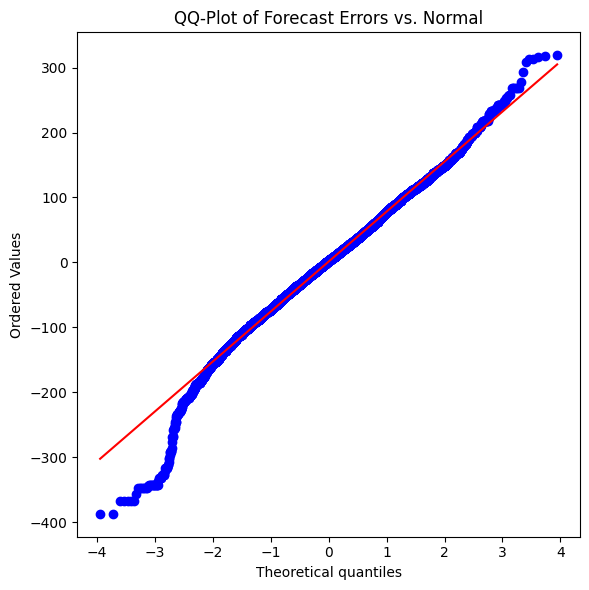

In [24]:
# Error distribution: histogram and QQ plot of forecast errors 
errors = df["error"].dropna().values

plt.figure(figsize=(10, 4))
plt.hist(errors, bins=50, edgecolor="black")
plt.title("Histogram of Forecast Errors")
plt.xlabel("Error (k jobs)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
stats.probplot(errors, dist="norm", plot=plt)
plt.title("QQ‐Plot of Forecast Errors vs. Normal")
plt.tight_layout()
plt.show()

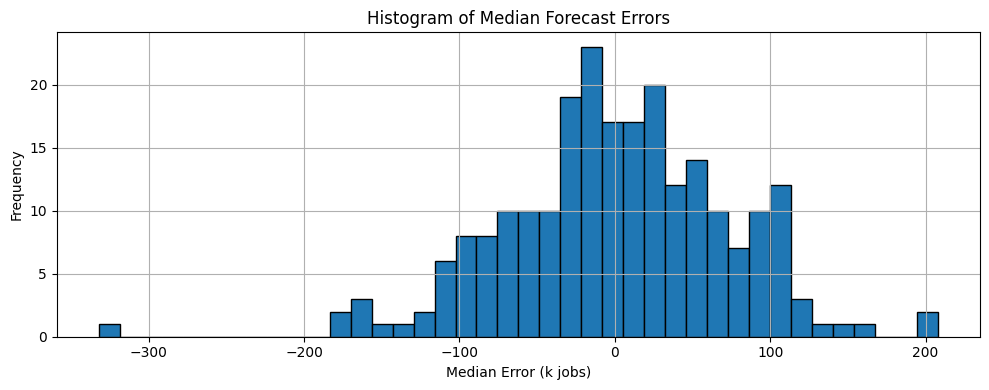

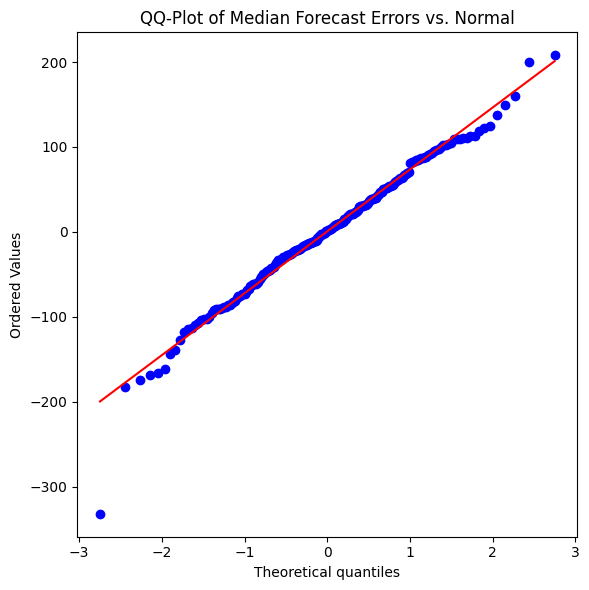

In [25]:
# Compute median forecast errors (one value per release)
median_errors = (
    df
    .drop_duplicates('release_date')  # keep one row per release
    .assign(median_err=lambda d: d['median_forecast'] - d['actual'])
    ['median_err']
    .values
)

# Histogram of median forecast errors
plt.figure(figsize=(10, 4))
plt.hist(median_errors, bins=40, edgecolor='black')
plt.title("Histogram of Median Forecast Errors")
plt.xlabel("Median Error (k jobs)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# QQ‐plot of median errors against a Normal distribution
plt.figure(figsize=(6, 6))
stats.probplot(median_errors, dist='norm', plot=plt)
plt.title("QQ‐Plot of Median Forecast Errors vs. Normal")
plt.tight_layout()
plt.show()


**Normality tests**

Unlikely given fat-tailed nature. We include this for completeness.

In [26]:
# --- Jarque-Bera on economist-level errors ----
jb_e_stat, jb_e_p = jarque_bera(errors)
print(f"Jarque–Bera (all economist errors) :  JB = {jb_e_stat:,.2f},  p = {jb_e_p:.4f}")

# --- Jarque-Bera on MEDIAN forecast errors -------------------------
jb_m_stat, jb_m_p = jarque_bera(median_errors)
print(f"Jarque–Bera (median errors)        :  JB = {jb_m_stat:,.2f},  p = {jb_m_p:.4f}")

if jb_m_p < 0.05:
    print("→ Reject normality of median errors at the 5 % level.")
else:
    print("→ Cannot reject normality of median errors at the 5 % level.")
    
    
# for reference: JB stat threshold for 5% threshold is approx. 6 

Jarque–Bera (all economist errors) :  JB = 1,055.35,  p = 0.0000
Jarque–Bera (median errors)        :  JB = 24.59,  p = 0.0000
→ Reject normality of median errors at the 5 % level.


## Student-t distribution test

KS and CvM goodness-of-fit test for student's t

Null: The sample comes from a fully-specified student-t CDF

KS emphasizes the worst mismatch, while CvM checks for a match in the overall shape. 

In [27]:
# fit parameters via MLE
nu_hat, loc_hat, scale_hat = st.t.fit(errors)

# Kolmogorov–Smirnov against fitted t
ks_stat, ks_p = st.kstest(errors, 't', args=(nu_hat, loc_hat, scale_hat))
print(f"K–S vs fitted t :  D = {ks_stat:.3f},  p = {ks_p:.4f}")

# Cramér–von Mises test (works for any callable CDF)
t_cdf = lambda x: st.t.cdf(x, df=nu_hat, loc=loc_hat, scale=scale_hat)
cvm_res = st.cramervonmises(errors, t_cdf)
print(f"CvM statistic   :  W² = {cvm_res.statistic:.3f},  p = {cvm_res.pvalue:.4f}")

K–S vs fitted t :  D = 0.012,  p = 0.0205
CvM statistic   :  W² = 0.199,  p = 0.2695


Student-t is adequate to model forecast errors in COVID-filtered dataframe. CvM denotes no meaningful deviation. KS rejection likely a large-sample artefact; visual inspection only shows miniscule departures.

In [28]:
# fit parameters via MLE
nu_hat, loc_hat, scale_hat = st.t.fit(median_errors)

# Kolmogorov–Smirnov against fitted t
ks_stat, ks_p = st.kstest(median_errors, 't', args=(nu_hat, loc_hat, scale_hat))
print(f"K–S vs fitted t :  D = {ks_stat:.3f},  p = {ks_p:.4f}")

# Cramér–von Mises test (works for any callable CDF)
t_cdf = lambda x: st.t.cdf(x, df=nu_hat, loc=loc_hat, scale=scale_hat)
cvm_res = st.cramervonmises(median_errors, t_cdf)
print(f"CvM statistic   :  W² = {cvm_res.statistic:.3f},  p = {cvm_res.pvalue:.4f}")

K–S vs fitted t :  D = 0.034,  p = 0.9393
CvM statistic   :  W² = 0.025,  p = 0.9903


For median errors, student-t models errors well. Both KS and CvM do not reject null (no statistical evidence that median-error distribution differs from student-t).

**Overlay fitted t PDF (Forecast errors, median errors)**

- Use parameters we found previously via MLE to fit the student-t
- Check curve against histogram if parametric model under or overestimates mass 

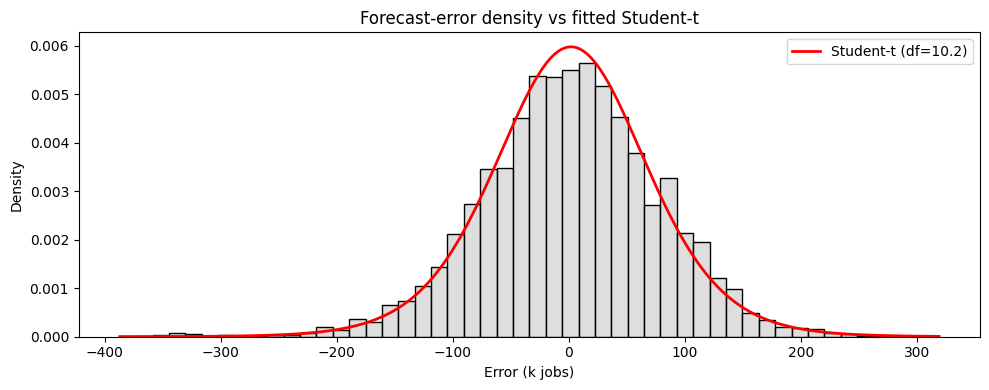

In [29]:
xgrid = np.linspace(errors.min(), errors.max(), 400)
pdf_t = st.t.pdf(xgrid, df=nu_hat, loc=loc_hat, scale=scale_hat)

plt.figure(figsize=(10,4))
sns.histplot(errors, bins=50, stat="density", edgecolor="k", color="lightgray")
plt.plot(xgrid, pdf_t, c="red", lw=2, label=f"Student-t (df={nu_hat:,.1f})")
plt.title("Forecast-error density vs fitted Student-t")
plt.xlabel("Error (k jobs)"); plt.ylabel("Density")
plt.legend(); plt.tight_layout(); plt.show()

No obvious bias present. Red t curve hugs grey bars well.

Let's try for median forecast errors:

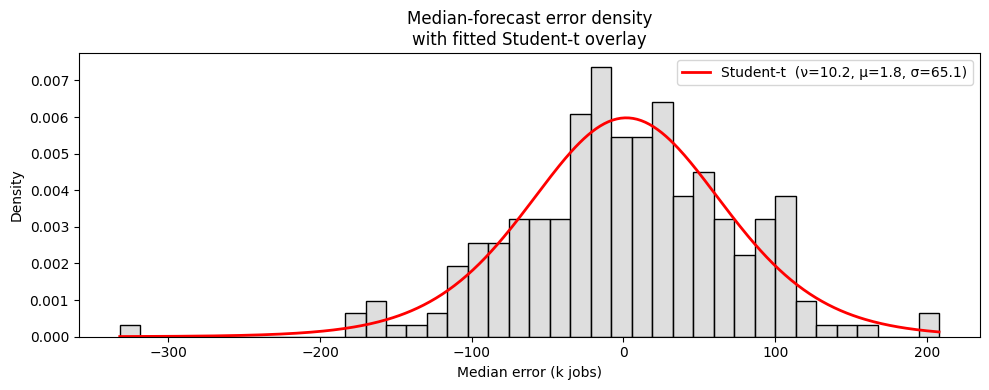

In [30]:
# MLE fit
nu_hat_median, loc_hat_median, scale_hat_median = st.t.fit(median_errors)

# Histogram + fitted Student-t PDF 
xgrid = np.linspace(median_errors.min(), median_errors.max(), 400)
pdf_t = st.t.pdf(xgrid,
                 df=nu_hat_median,
                 loc=loc_hat_median,
                 scale=scale_hat_median)

plt.figure(figsize=(10,4))
sns.histplot(median_errors,
             bins=40, stat="density",
             edgecolor="k", color="lightgray")
plt.plot(xgrid, pdf_t, c="red", lw=2,
         label=f"Student-t  (ν={nu_hat_median:.1f}, μ={loc_hat_median:.1f}, σ={scale_hat_median:.1f})")
plt.title("Median-forecast error density\nwith fitted Student-t overlay")
plt.xlabel("Median error (k jobs)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


**Tail-probability calibration plot**
- Two sided tail probability for each error 
- For every absolute error: Under the fitted student-t, what is the probability of seeing a value at least as extreme as this? 
- Output p-value between 0 and 1 
- Sorted p-values plotted against uniform [0,1] grid
- If fitted distribution were perfect, empirical CDF would hug the diagonal

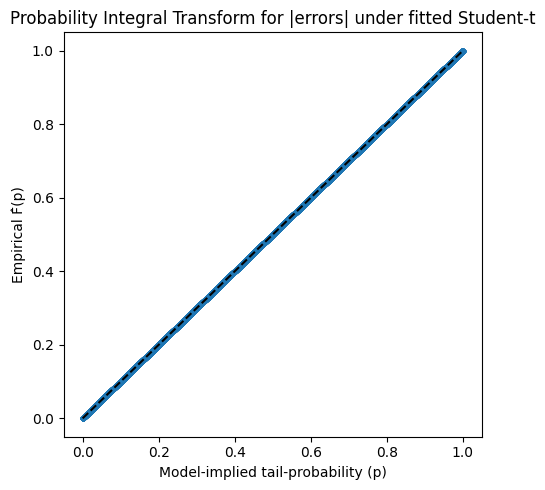

In [31]:
tail_pvals = 2*(1 - st.t.cdf(np.abs(errors), df=nu_hat, loc=0, scale=scale_hat))
tail_pvals.sort()
n = len(tail_pvals)

plt.figure(figsize=(5,5))
plt.plot(np.linspace(0,1,n), np.arange(1,n+1)/n, marker=".", ls="")
plt.plot([0,1],[0,1], "k--")
plt.xlabel("Model-implied tail-probability (p)"); plt.ylabel("Empirical F̂(p)")
plt.title("Probability Integral Transform for |errors| under fitted Student-t")
plt.tight_layout(); plt.show()


**Contribution of tails to RMSE**

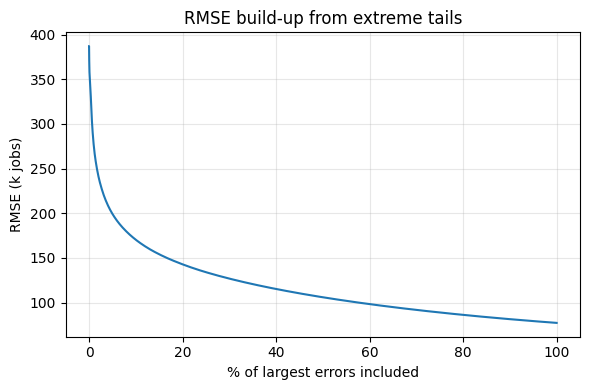

In [32]:
abs_err = np.abs(errors)
sorted_abs = np.sort(abs_err)[::-1]           # biggest first
cum_mse = np.cumsum(sorted_abs**2)
cum_rmse = np.sqrt(cum_mse / np.arange(1,len(errors)+1))

plt.figure(figsize=(6,4))
plt.plot(np.arange(1,len(errors)+1)/len(errors)*100, cum_rmse)
plt.xlabel("% of largest errors included"); plt.ylabel("RMSE (k jobs)")
plt.title("RMSE build-up from extreme tails"); plt.grid(alpha=.3); plt.tight_layout(); plt.show()

Few gigantic errors dominate RMSE; heavy tail risk --> consider trimming (winsorize) or robust loss (student-t, Huber, quantile)

**Skewness vs. time**

- For every month t, compute sample skewness of previous 12 releases 
- Plot rolling window skewness 

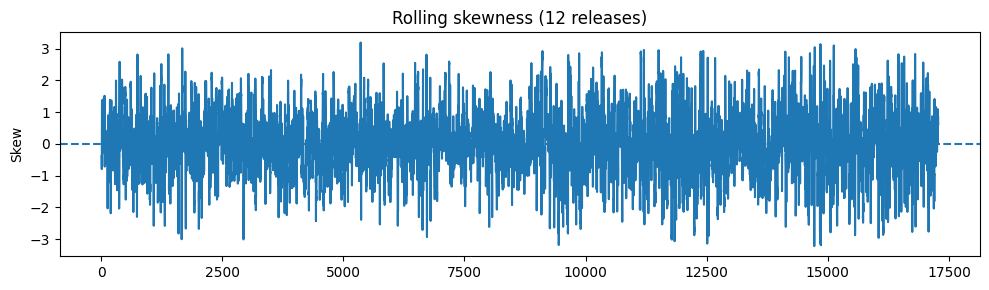

In [33]:
roll_skew = pd.Series(errors).rolling(12).skew()
roll_skew.plot(figsize=(10,3), title="Rolling skewness (12 releases)")
plt.axhline(0, ls="--"); plt.ylabel("Skew"); plt.tight_layout(); plt.show()

Forecasts centered correctly on average. Spikes represent fat-tail risk.

**Student-t implied parameters (forecast errors, median errors)**

In [34]:
nu, loc, scale = nu_hat, loc_hat, scale_hat       # from st.t.fit(...)
var   = scale**2 * nu / (nu-2)        if nu > 2 else np.inf
kurt  = 6 / (nu-4)                    if nu > 4 else np.inf

print("Student-t parameters:")
print(f"nu: {nu}")
print(f"loc: {loc}")
print(f"scale: {scale}\n")

print("Moments:")
print(f"Mean = {loc_hat}")
print(f"Var    = {var:6.2f}")
print(f"Skewness = 0 (Symmetric)")
print(f"Ex.Kurt= {kurt:6.2f}")

Student-t parameters:
nu: 10.166123819335795
loc: 1.8397855280559008
scale: 65.12477434120375

Moments:
Mean = 1.8397855280559008
Var    = 5279.98
Skewness = 0 (Symmetric)
Ex.Kurt=   0.97


In [35]:
# Median forecast errors --> fitted MLE params
print("Fitted Student-t parameters (MLE)")
print(f"ν  (degrees-of-freedom) : {nu_hat_median:6.2f}")
print(f"μ  (location / mean)    : {loc_hat_median:6.2f}  k jobs")
print(f"σ  (scale)              : {scale_hat_median:6.2f}  k jobs\n")

# Analytical moments 
mean_val  = loc_hat_median
variance  = (scale_hat_median**2 * nu_hat_median / (nu_hat_median - 2)
             if nu_hat_median > 2 else np.inf)
skewness  = 0                                      # symmetry
ex_kurt   = (6 / (nu_hat_median - 4)
             if nu_hat_median > 4 else np.inf)

print("Implied theoretical moments")
print(f"Mean            : {mean_val:6.2f}  k jobs")
print(f"Variance        : {variance:6.2f}")
print(f"Skewness        : {skewness}")
print(f"Excess kurtosis : {ex_kurt:6.2f}")


Fitted Student-t parameters (MLE)
ν  (degrees-of-freedom) :  10.17
μ  (location / mean)    :   1.84  k jobs
σ  (scale)              :  65.12  k jobs

Implied theoretical moments
Mean            :   1.84  k jobs
Variance        : 5279.98
Skewness        : 0
Excess kurtosis :   0.97


**Confidence Intervals - Toy Example**

Toy example of how we can compute confidence intervals for point forecasts bases off student-t error distribution

In [36]:
def student_t_interval(point_forecast, nu=7.418464693617684, loc=5.192769902441414, scale=69.74945424622365, level=0.95):
    """Return lower, upper bounds of a (1-α) prediction interval."""
    q = st.t.ppf(1 - (1 - level)/2, df=nu)  # two-sided critical value
    lower = point_forecast + loc - q * scale
    upper = point_forecast + loc + q * scale
    return lower, upper

In [37]:
# example for the upcoming release
y_hat = 180        # example smart forecast
low, high = student_t_interval(
    y_hat, nu_hat, loc_hat, scale_hat, level=0.9
)
print(f"90 % interval: ({low:.1f},{high:.1f}) k")

90 % interval: (64.0,299.7) k


**Cross-Sectional Spread**

In this section, we'll perform some tests to check if cross-sectional spread can inform us about confidence interval widths. 


COVID panel:
  Pearson  r =  0.160  (p = 0.0151)
  Spearman ρ =  0.170  (p = 0.0098)

Full panel:
  Pearson  r =  0.704  (p = 0.0000)
  Spearman ρ =  0.338  (p = 0.0000)


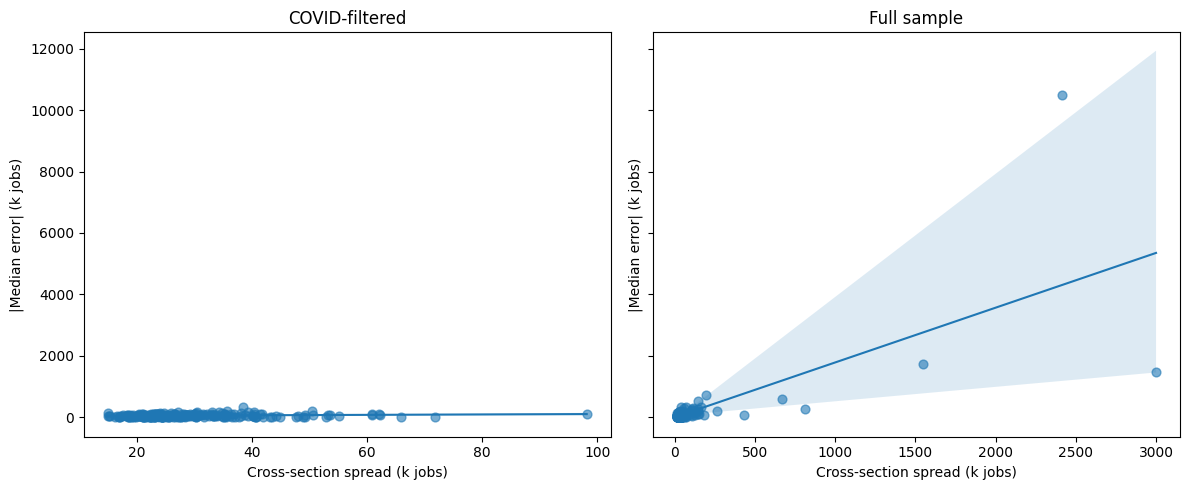

In [ ]:
# Helper to build (date, spread, abs_err) table
def build_spread_df(panel: pd.DataFrame, label: str) -> pd.DataFrame:
    """Return DataFrame with release_date, spread, abs_err for a panel."""
    # cross-sectional std of forecasts
    spread = (panel.groupby("release_date")["forecast"]
                     .std(ddof=0)                # population SD
                     .rename("spread"))
    # median forecast & actual
    med_act = (panel.groupby("release_date")
                     .agg(median_fc=("forecast", "median"),
                          actual    =("actual",   "first")))
    med_act["abs_err"] = (med_act["median_fc"] - med_act["actual"]).abs()
    out = med_act.join(spread).reset_index()
    out["panel"] = label
    return out.dropna(subset=["spread"])         # ensure SD defined

covid_tbl  = build_spread_df(df,       "COVID")
full_tbl   = build_spread_df(df_full,  "Full")

# Correlation summary
for tbl, name in [(covid_tbl, "COVID"), (full_tbl, "Full")]:
    pearson  = stats.pearsonr(tbl["spread"], tbl["abs_err"])
    spearman = stats.spearmanr(tbl["spread"], tbl["abs_err"])
    print(f"\n{name} panel:")
    print(f"  Pearson  r = {pearson.statistic:6.3f}  (p = {pearson.pvalue:.4f})")
    print(f"  Spearman ρ = {spearman.statistic:6.3f}  (p = {spearman.pvalue:.4f})")


# Scatter plots
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for ax, tbl, title in zip(axs, [covid_tbl, full_tbl], ["COVID-filtered", "Full sample"]):
    sns.regplot(data=tbl, x="spread", y="abs_err",
                scatter_kws={"alpha":0.6, "s":40}, line_kws={"linewidth":1.5}, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Cross-section spread (k jobs)")
    ax.set_ylabel("|Median error| (k jobs)")

plt.tight_layout()
plt.show()

In [39]:
# Influence diagnostics

# fit ols, get cook's D
X = sm.add_constant(full_tbl["spread"])
model      = sm.OLS(full_tbl["abs_err"], X).fit()
full_tbl["cooksD"] = model.get_influence().cooks_distance[0]

# Flag influential points:  D_i > 4 / n
n_obs          = len(full_tbl)
cutoff         = 4 / n_obs
infl_tbl       = full_tbl[full_tbl["cooksD"] > cutoff]        # keep only influential
infl_tbl       = infl_tbl.sort_values("cooksD", ascending=False)

print(f"Cook’s-D cutoff (4/n) = {cutoff:.4f}  |  n influential = {len(infl_tbl)}")

# Display the influential releases
cols_to_show = ["release_date", "spread", "abs_err", "cooksD"]
display(infl_tbl[cols_to_show]
        .style.format({"spread": "{:.1f}", "abs_err": "{:.1f}", "cooksD": "{:.4f}"}))

Cook’s-D cutoff (4/n) = 0.0150  |  n influential = 5


,release_date,spread,abs_err,cooksD
205,2020-05-08 00:00:00,2999.7,1463.0,62.9130
206,2020-06-05 00:00:00,2415.5,10509.0,57.8199
207,2020-07-02 00:00:00,1550.9,1742.0,0.3970
208,2020-08-07 00:00:00,812.1,263.0,0.1188
204,2020-04-03 00:00:00,671.4,601.0,0.0204


- Information content exists in the cross-section: a wider cross-section signals higher risk that the median will miss
- Regime dependency: Relationship strengthens dramatically in crisis periods (see much higher Pearson correlation) when both disagreement and errors explode. In full sample, Spearman << Pearson, telling us that the strength of the linear fit is dominated by a subset of extreme-error months (refer to co).
- Complementary to current GARCH/EWMA approaches: GARCH reacts **after** a big miss. Cross-sectional spread is available before the print 
- Could try combining the two to improve tail coverage in crisis regimes

*Regression Test*

Run OLS with robust (Newey-West) standard errors to model spread-median error relationship. 

ln | error_t | = beta_0 + beta_1 * ln(spread_t) + epsilon_t

In [40]:
tbl = covid_tbl        # COVID-filtered
# drop zero‐spread rows to avoid log(0)
tbl = tbl[tbl["spread"] > 0]

y = np.log(tbl["abs_err"])
X = sm.add_constant(np.log(tbl["spread"]))
ols = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": 12})
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                abs_err   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.263
Date:                Mon, 30 Jun 2025   Prob (F-statistic):              0.262
Time:                        14:56:18   Log-Likelihood:                -350.71
No. Observations:                 231   AIC:                             705.4
Df Residuals:                     229   BIC:                             712.3
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7339      0.741      3.691      0.0

In [41]:
tbl = full_tbl       # full sample
# drop zero‐spread rows to avoid log(0)
tbl = tbl[tbl["spread"] > 0]

y = np.log(tbl["abs_err"])
X = sm.add_constant(np.log(tbl["spread"]))
ols = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": 12})
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                abs_err   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     97.27
Date:                Mon, 30 Jun 2025   Prob (F-statistic):           9.54e-20
Time:                        14:56:18   Log-Likelihood:                -410.16
No. Observations:                 267   AIC:                             824.3
Df Residuals:                     265   BIC:                             831.5
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9722      0.276      3.517      0.0

- Disagreement (large spread in the cross-section) adds signal, but mostly in crisis extremes (R2 is low outside of that)
- in 2020-2022, spread is critical. Forecasters disagree widely and errors explode
- Let's try a routine where in normal times, we use the COVID-filtered B_1 multiplier, and then use a larger multiplier using a crisis indicator (spread above historical 95th pct)

**Check Student-t diagnostics for smart forecast**

Build smart series:   0%|          | 0/219 [00:00<?, ?it/s]


Built smart-forecast series: 219 releases

Fitted Student-t parameters (MLE)
nu (df)   :   9.08
mu (loc)  :   0.51  k jobs
sigma     :  62.93  k jobs

Sample vs implied theoretical moments


,Sample,Student_t
Mean,-0.880387,0.510538
Variance,5127.908567,5079.213384
Skew,-0.410666,0.000000
ExKurtosis,1.420624,1.180731



Goodness-of-fit tests
Jarque-Bera          : JB =      24.57, p = 0.0000
Kolmogorov-Smirnov   : D  =      0.033, p = 0.9663
Cramer-von Mises     : W2 =      0.031, p = 0.9721


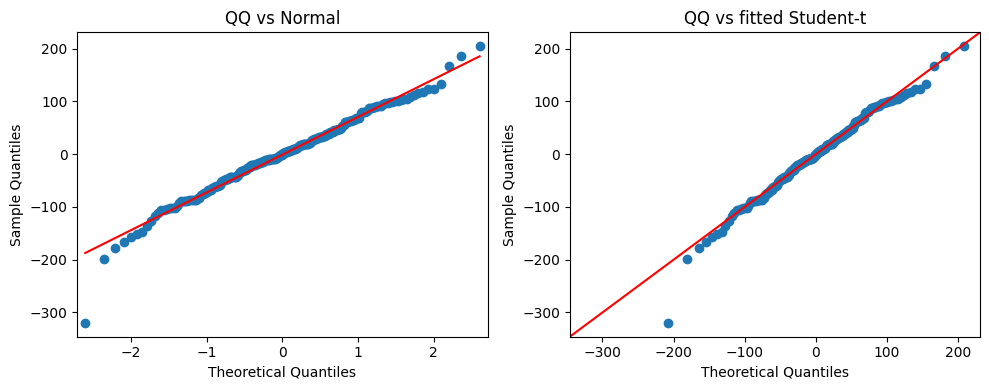

Rolling coverage:   0%|          | 0/183 [00:00<?, ?it/s]


Rolling-origin coverage (expanding Student-t)


,Nominal,Empirical
0,0.500,0.519
1,0.600,0.607
2,0.700,0.694
3,0.800,0.803
4,0.900,0.923
5,0.950,0.962
6,0.990,0.995


In [ ]:
# ==============================================================
# 12-month inverse-MSE smart-forecast diagnostics 
# ==============================================================

# ------------------------------------------------------------------
# 0.  Select the panel you want to test
# ------------------------------------------------------------------
PANEL = df            # use df  (COVID-filtered)  or df_full (full sample)

# ------------------------------------------------------------------
# 1. Build 12-month smart forecast & error series
# ------------------------------------------------------------------
LOOKBACK = 12
RIDGE    = 1e-6       # stabiliser for 1/MSE weights

dates_all = np.sort(PANEL["release_date"].unique())
records   = []

for idx in tqdm(range(LOOKBACK, len(dates_all)), desc="Build smart series"):
    t       = dates_all[idx]
    window  = dates_all[idx - LOOKBACK : idx]

    hist = PANEL[PANEL["release_date"].isin(window)]

    # economists with forecasts for ALL months in the window
    valid = hist.groupby("economist")["forecast"].apply(lambda s: s.notna().all())
    econs = valid[valid].index
    if econs.empty:
        continue

    # mean squared error for each economist
    mse = (hist[hist["economist"].isin(econs)]
           .groupby("economist")["error"]
           .apply(lambda s: np.nanmean(np.square(s))))
    weights = 1.0 / (mse + RIDGE)
    weights /= weights.sum()

    # current forecasts from those economists
    cur = PANEL[(PANEL["release_date"] == t) & (PANEL["economist"].isin(weights.index))]
    f_t = cur.set_index("economist")["forecast"].dropna()
    weights = weights.reindex(f_t.index).dropna()
    if weights.empty:
        continue
    weights /= weights.sum()          # renormalise (in case some forecasts missing)

    smart  = np.dot(weights, f_t.loc[weights.index])
    actual = PANEL.loc[PANEL["release_date"] == t, "actual"].iloc[0]
    records.append((t, smart, actual))

oos = pd.DataFrame(records, columns=["date", "smart", "actual"])
oos["err"] = oos["smart"] - oos["actual"]
errs = oos["err"].values
print(f"\nBuilt smart-forecast series: {len(oos)} releases")

# ------------------------------------------------------------------
# 2. Fit Student-t to ALL smart-forecast errors
# ------------------------------------------------------------------
nu_hat, loc_hat, scale_hat = st.t.fit(errs)

sample_mom = pd.Series({
    "Mean":      errs.mean(),
    "Variance":  errs.var(ddof=1),
    "Skew":      st.skew(errs),
    "ExKurtosis":st.kurtosis(errs, fisher=True)
})

theor_mom = pd.Series({
    "Mean":      loc_hat,
    "Variance":  st.t.var(nu_hat, scale=scale_hat),
    "Skew":      0.0,
    "ExKurtosis":st.t.stats(nu_hat, moments="k", scale=scale_hat)
})

print("\nFitted Student-t parameters (MLE)")
print(f"nu (df)   : {nu_hat:6.2f}")
print(f"mu (loc)  : {loc_hat:6.2f}  k jobs")
print(f"sigma     : {scale_hat:6.2f}  k jobs")

print("\nSample vs implied theoretical moments")
display(pd.concat({"Sample": sample_mom, "Student_t": theor_mom}, axis=1))

# ------------------------------------------------------------------
# 3. Goodness-of-fit tests
# ------------------------------------------------------------------
jb_stat, jb_p     = st.jarque_bera(errs)
ks_stat, ks_p     = st.kstest(errs, "t", args=(nu_hat, loc_hat, scale_hat))
cvm_res           = st.cramervonmises(
    errs,
    lambda x: st.t.cdf(x, df=nu_hat, loc=loc_hat, scale=scale_hat)
)

print("\nGoodness-of-fit tests")
print(f"Jarque-Bera          : JB = {jb_stat:10.2f}, p = {jb_p:.4f}")
print(f"Kolmogorov-Smirnov   : D  = {ks_stat:10.3f}, p = {ks_p:.4f}")
print(f"Cramer-von Mises     : W2 = {cvm_res.statistic:10.3f}, p = {cvm_res.pvalue:.4f}")

# ------------------------------------------------------------------
# 4. QQ plots
# ------------------------------------------------------------------
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
sm.qqplot(errs, line="s", ax=axs[0])
axs[0].set_title("QQ vs Normal")
sm.qqplot(errs, dist=st.t, distargs=(nu_hat,),
          loc=loc_hat, scale=scale_hat, line="45", ax=axs[1])
axs[1].set_title("QQ vs fitted Student-t")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 5. Rolling-origin (expanding) coverage test
# ------------------------------------------------------------------
LEVELS    = [0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
MIN_TRAIN = 36

hits = defaultdict(int)
totN = 0

for i in tqdm(range(MIN_TRAIN, len(oos)), desc="Rolling coverage"):
    train_errs = oos.iloc[:i]["err"].values
    nu_i, mu_i, sigma_i = st.t.fit(train_errs)

    point  = oos.iloc[i]["smart"]
    actual = oos.iloc[i]["actual"]

    for L in LEVELS:
        q = st.t.ppf(1 - (1 - L) / 2.0, df=nu_i)
        half = q * sigma_i
        if (point + mu_i - half) <= actual <= (point + mu_i + half):
            hits[L] += 1
    totN += 1

coverage = pd.DataFrame({
    "Nominal": LEVELS,
    "Empirical": [hits[L] / totN for L in LEVELS]
})

print("\nRolling-origin coverage (expanding Student-t)")
display(coverage.style.format("{:.3f}"))

**Appendix - Student-t diagnostics for df_full**

In [51]:
def t_diag(err_vec: np.ndarray, label: str) -> None:
    """Fit Student-t to err_vec and print basic GOF statistics."""
    nu, mu, sigma = st.t.fit(err_vec)
    jb_stat, jb_p = st.jarque_bera(err_vec)
    ks_stat, ks_p = st.kstest(err_vec, 't', args=(nu, mu, sigma))
    cvm_res       = st.cramervonmises(err_vec,
                        lambda x: st.t.cdf(x, df=nu, loc=mu, scale=sigma))

    print(f"\n[{label}]  n = {len(err_vec)}")
    print(f"  nu    = {nu:6.2f}")
    print(f"  mu    = {mu:7.2f} k")
    print(f"  sigma = {sigma:7.2f} k")
    print(f"  Jarque-Bera          : {jb_stat:9.2f}  (p = {jb_p:.4f})")
    print(f"  Kolmogorov-Smirnov   : {ks_stat:9.3f}  (p = {ks_p:.4f})")
    print(f"  Cramer-von Mises     : {cvm_res.statistic:9.3f}  (p = {cvm_res.pvalue:.4f})")

# Median-forecast errors on df_full
median_err_full = (
    df_full
    .groupby("release_date")
    .apply(lambda d: d["median_forecast"].iloc[0] - d["actual"].iloc[0])
    .values
)
t_diag(median_err_full, "Median errors (df_full)")

# 12-month inverse-MSE smart-forecast errors on df_full
LOOKBACK = 12
RIDGE    = 1e-6
dates    = np.sort(df_full["release_date"].unique())
smart_errs = []

for idx in tqdm(range(LOOKBACK, len(dates)), desc="Building smart residuals"):
    t_date  = dates[idx]
    window  = dates[idx-LOOKBACK:idx]

    hist    = df_full[df_full["release_date"].isin(window)]
    valid   = hist.groupby("economist")["forecast"].apply(lambda s: s.notna().all())
    econs   = valid[valid].index
    if econs.empty:
        continue

    mse     = (hist[hist["economist"].isin(econs)]
               .groupby("economist")["error"]
               .apply(lambda s: np.nanmean(s**2)))
    w       = 1 / (mse + RIDGE)
    w       = w / w.sum()

    cur     = df_full[(df_full["release_date"] == t_date) &
                      (df_full["economist"].isin(w.index))]
    f_t     = cur.set_index("economist")["forecast"].dropna()
    w       = w.loc[w.index.intersection(f_t.index)]
    if w.empty:
        continue
    w       = w / w.sum()

    smart   = np.dot(w, f_t.loc[w.index])
    actual  = df_full.loc[df_full["release_date"] == t_date, "actual"].iloc[0]
    smart_errs.append(smart - actual)

t_diag(np.asarray(smart_errs), "Smart errors (12-mo, df_full)")



[Median errors (df_full)]  n = 267
  nu    =   1.90
  mu    =   -1.18 k
  sigma =   59.05 k
  Jarque-Bera          : 576832.48  (p = 0.0000)
  Kolmogorov-Smirnov   :     0.036  (p = 0.8660)
  Cramer-von Mises     :     0.042  (p = 0.9233)


C:\Users\nwong\AppData\Local\Temp\ipykernel_23232\1894196975.py:21: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: d["median_forecast"].iloc[0] - d["actual"].iloc[0])


Building smart residuals:   0%|          | 0/255 [00:00<?, ?it/s]


[Smart errors (12-mo, df_full)]  n = 255
  nu    =   1.76
  mu    =   -0.17 k
  sigma =   55.97 k
  Jarque-Bera          : 529897.30  (p = 0.0000)
  Kolmogorov-Smirnov   :     0.036  (p = 0.8878)
  Cramer-von Mises     :     0.045  (p = 0.9043)


- Student-t with v $\approx$ 1.9 fits well
- Normality soundly rejected
- Smart forecast (mu effectively zero) is unbiased overall 
- Tail risk dominates: need to account for black swan events in coverage, or use adaptive devices 
- Full sample has VERY heavy tails